# 5. Let's Make a Lane Detection Pipeline  
1. Gray Scale
2. Gaussian Smoothing
3. Canny Edge Detection
4. Region Masking
5. Hough Transform
6. Draw Lines [Mark Lane Lines with different Color]

In [129]:
import math
import keyboard
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def draw_lines(img, lines, thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2),  thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # comme /
    right_lines = [] # comme \
    size_right = []
    size_left = []
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y2 - m * x2

                if m < 0:
                    right_lines.append((m,c))


                    cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 9)
                    size1 = (x2 - x1)**2 + (y2- y1)**2
                    size2 = math.sqrt(size1)
                    size_right.append(size2)

                    
                        
                    
                elif m >= 0:
                    left_lines.append((m,c))

                    cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 9)
                    
                    size1 = (x2 - x1)**2 + (y2- y1)**2
                    size2 = math.sqrt(size1)
                    
                    size_left.append(size2)
                
                    

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)
    
    sizeRight = np.mean(size_right,axis=0)
    sizeLeft = np.mean(size_left,axis=0)

    # print("Left "+str(len(size_left))+"\nRight :"+str(len(size_right)))


    for slope, intercept in [left_line, right_line]:
        

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (255,255,255))
    img_weighted = cv2.addWeighted(image,0.7,img,0.4,0.)
    # print(len(left_lines))
    # print(len(right_lines))
    return [img_weighted,len(left_lines),len(right_lines)]
    


   

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)[0]
    return np.array([line_img,lines])

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]

    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 

    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [130]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)[0]
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return [output,masked_img]

# Test our Algorithm Pipeline with different Images

C:\Users\HP\AppData\Local\Temp\ipykernel_3588\2947917439.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([line_img,lines])


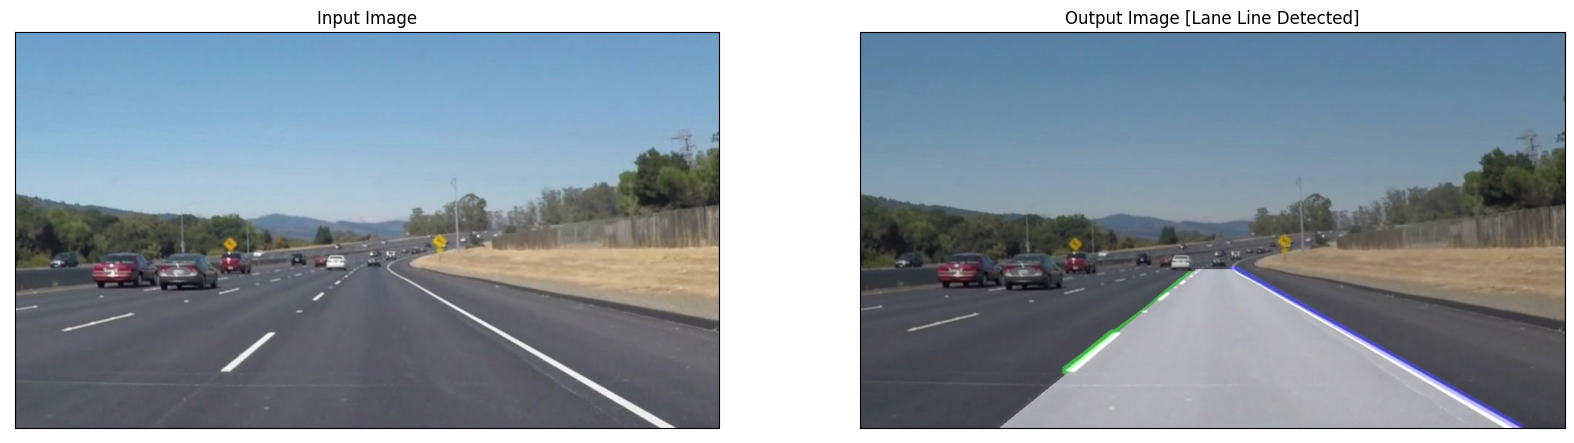

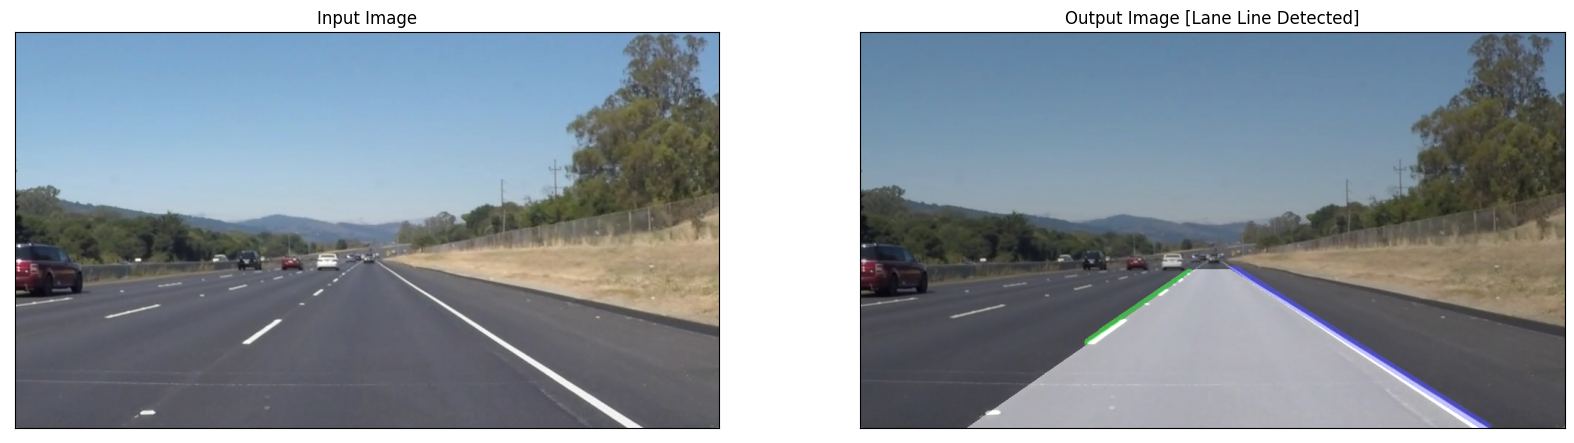

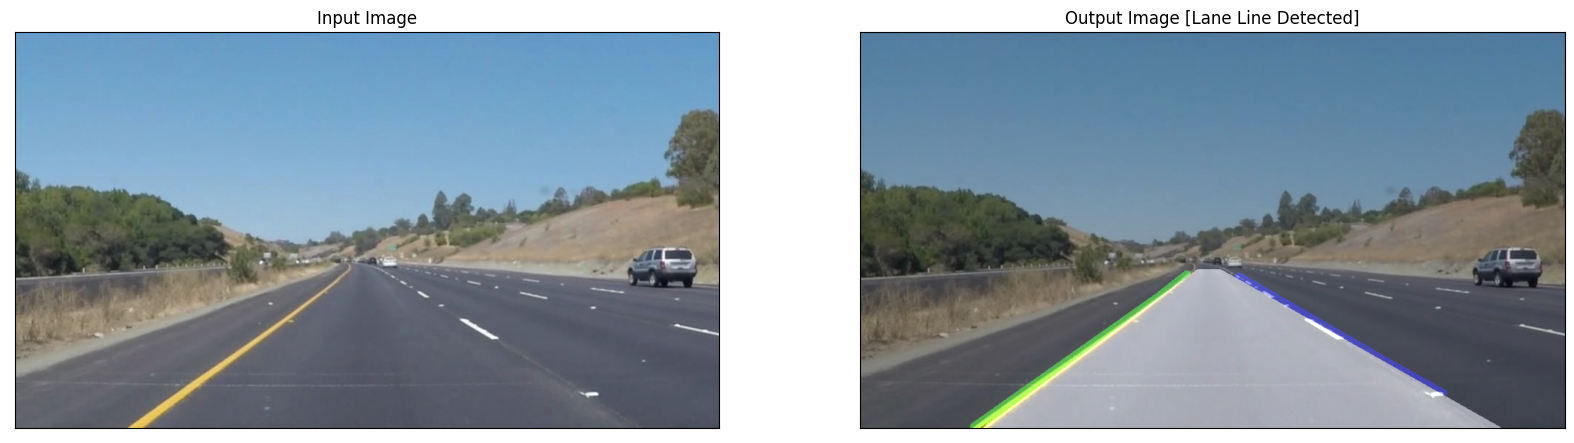

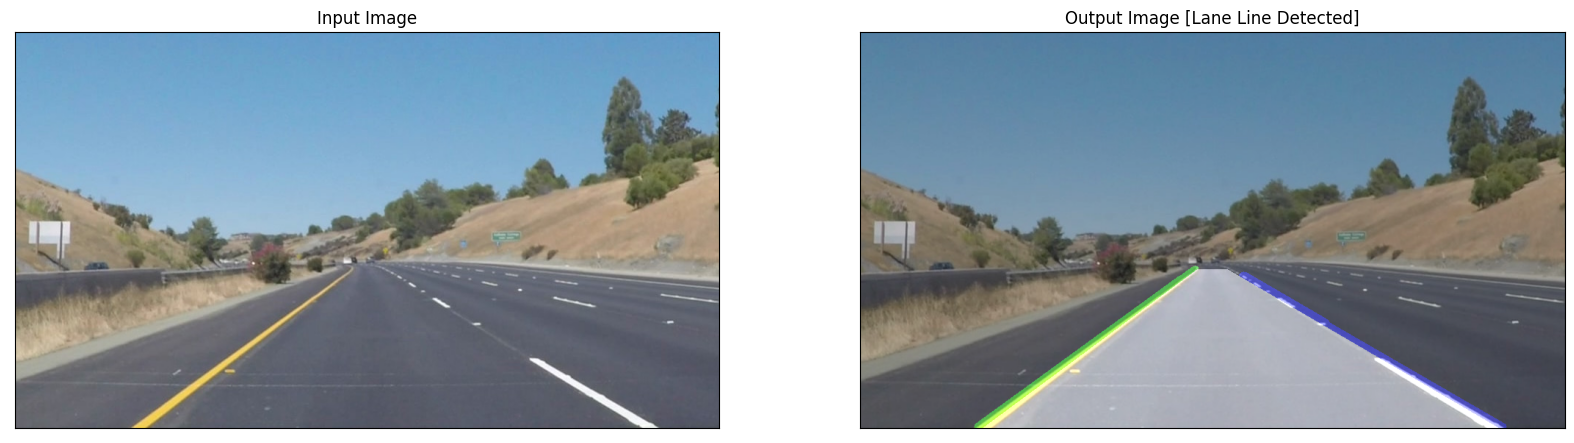

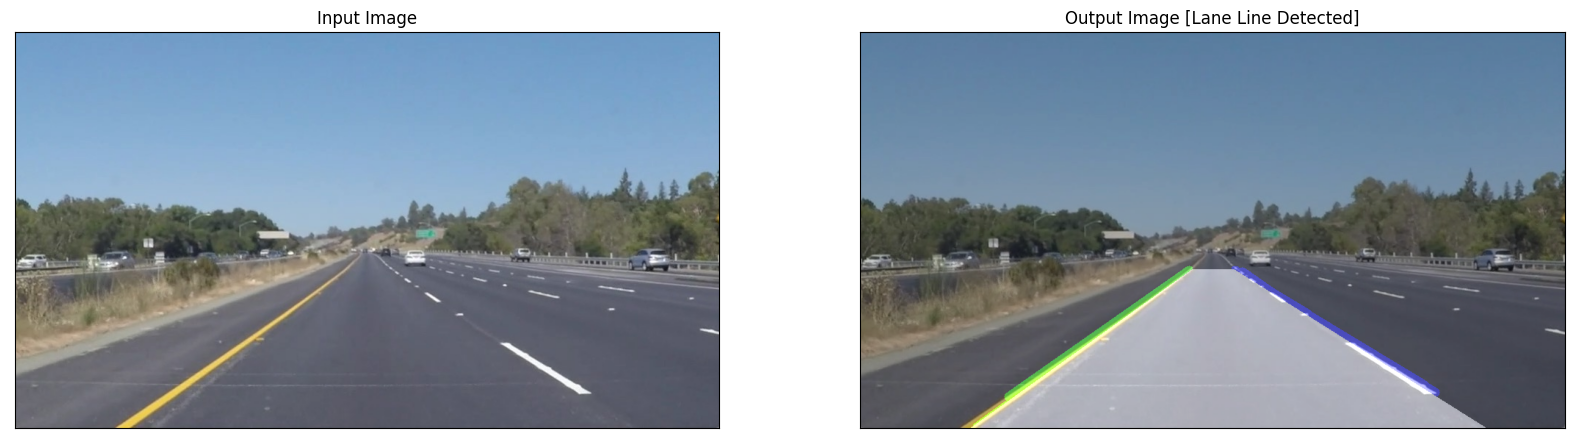

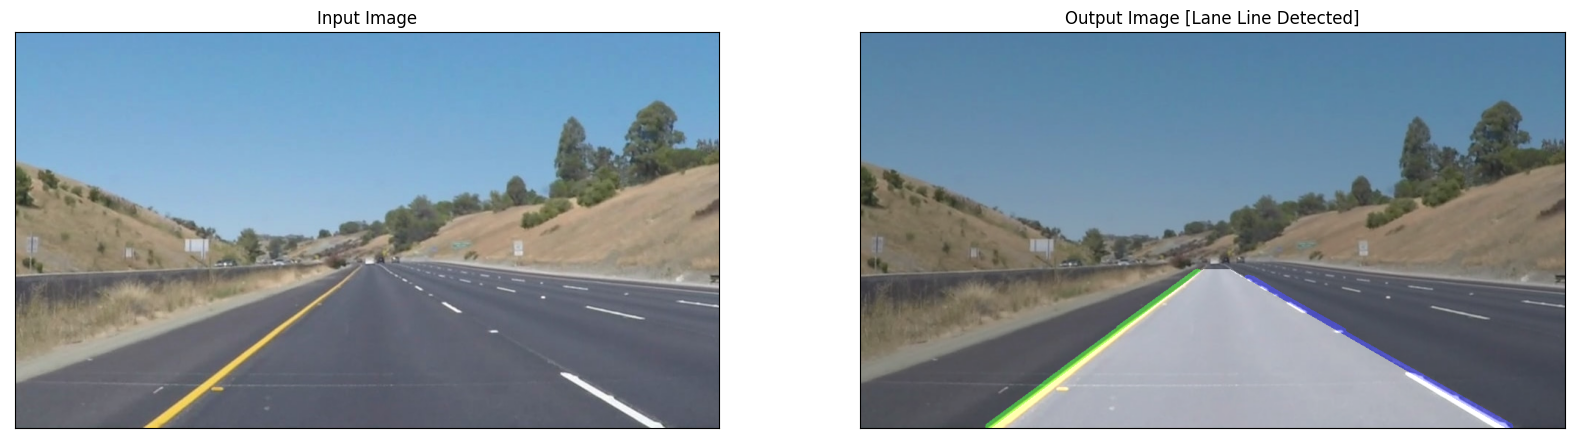

In [131]:
import os


for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image)[0])
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()

## **Test with Video Clip 1 [Solid White Lane Lines]**

In [132]:
# import cv2

# Ouvrez la vidéo en utilisant cv2.VideoCapture
capture = cv2.VideoCapture("solidWhiteRight.mp4")

# Boucle tant que la vidéo est ouverte
while capture.isOpened():
    # Lisez le cadre actuel de la vidéo
    ret, frame = capture.read()

    # Vérifiez si la vidéo est terminée
    if not ret:
        break

    # Affichez le cadre actuel de la vidéo à l'écran
    
    frame = lane_finding_pipeline(frame)[0]
    cv2.imshow("Video", frame)

    

    # Attendre une touche pour mettre en pause/continuer la lecture de la vidéo
    key = cv2.waitKey(30) & 0xff
    if key == 27:  # Appuyez sur Echap pour quitter
        break
    elif key == 32:  # Appuyez sur espace pour mettre en pause/continuer
        cv2.waitKey(0)
    elif key == 49: #numéro 1
        print("signal à gauche")
        cv2.imwrite("tested.jpg",lane_finding_pipeline(frame)[1])
        
        image = cv2.imread("tested.jpg")

        # Split the image into two halves
        height, width, _ = image.shape
        left_half = image[:, :480]
        right_half = image[:, 480:]

        # Count the number of white pixels in each half
        left_half_white_pixels = 0
        right_half_white_pixels = 0

        for row in left_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    left_half_white_pixels += 1

        for row in right_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    right_half_white_pixels += 1

        if left_half_white_pixels <501 :
            print("sir doubli ela molana")

        
        
       
       
       
       
       
       
        
    elif key == 50: #numéro 2
        print("signal à droite")
        cv2.imwrite("tested.jpg",lane_finding_pipeline(frame)[1])
        
        image = cv2.imread("tested.jpg")

        # Split the image into two halves
        height, width, _ = image.shape
        left_half = image[:, :480]
        right_half = image[:, 480:]

        # Count the number of white pixels in each half
        left_half_white_pixels = 0
        right_half_white_pixels = 0

        for row in left_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    left_half_white_pixels += 1

        for row in right_half:
            for pixel in row:
                if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                    right_half_white_pixels += 1

        if right_half_white_pixels >501 :
            print("fen ghadi a mo7amed")
        

# Fermez la vidéo et toutes les fenêtres ouvertes
capture.release()
cv2.destroyAllWindows()


C:\Users\HP\AppData\Local\Temp\ipykernel_3588\2947917439.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([line_img,lines])


signal à droite
fen ghadi a mo7amed
signal à gauche
sir doubli ela molana
